## Import libraries:

In [1]:
from gear.iocontract.utils import getVarlist
from PIL import Image
from gear.terms.polyhedra.loaders import readContract, writeContract
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib import patches
import pdb
from matplotlib.collections import PatchCollection

### Simple Example with pedestrian 5 steps away

In [2]:
## System contract: P >= 0.99
def system_contract():
    system_contract = {
        "input_vars":[
            "x_e"
        ],
        "output_vars":[
            "P"
        ],
        "assumptions":
        [
            {"coefficients":{"x_e":-1}, "constant":-1},
            {"coefficients":{"x_e":1}, "constant":1}
        ],
        "guarantees":
        [
            {"coefficients":{"P":-1},
            "constant":-0.99},
            {"coefficients":{"P":1},
            "constant":1}
        ]}
    return system_contract

## Perception contract P = p**5 = 5p - 4
# Control contract for pedestrian
def control_contract():
    mc= dict()
    mc = {"input_vars":["p"],
        "output_vars":[
            "P"
        ],
        "assumptions":
        [
            {"coefficients":{"p":1},
            "constant":1},
            {"coefficients":{"p":-1},
            "constant":0}
        ],
        "guarantees":
        [
          {"coefficients":{"P":1, "p":-5},
          "constant":-4},
          {"coefficients":{"P":-1, "p":5},
          "constant":4}
        ]}
    return mc



Cs = readContract(system_contract())
Ck = readContract(control_contract())

print("Overall System Contract:\n" + str(Cs)+"\n")
print("Controller Contract:\n" + str(Ck)+"\n")

Cp = Cs.quotient(Ck)
print("Quotient Contract:\n" + str(Cp)+"\n")

Overall System Contract:
InVars: [<Var x_e>]
OutVars:[<Var P>]
A: -1*x_e <= -1, 1*x_e <= 1
G: -1*P <= -0.99, 1*P <= 1.0

Controller Contract:
InVars: [<Var p>]
OutVars:[<Var P>]
A: 1*p <= 1, -1*p <= 0
G: 1*P + -5*p <= -4, -1*P + 5*p <= 4

Quotient Contract:
InVars: [<Var x_e>]
OutVars:[<Var p>]
A: -1*x_e <= -1, 1*x_e <= 1
G: -5*p <= -4.99000000000000, 1*p <= 1



In [3]:
TILESIZE = 50
ORIENTATIONS = {'n': 270, 'e': 0, 's': 90,'w':180, 'ne':315, 'nw':225, 'se':45, 'sw':135}
START_CROSSWALK = -1
END_CROSSWALK = 2
CROSSWALK_V = 1
CROSSWALK_LOCATIONS = dict()
ped_loc = []
for i, num in enumerate(range(2*START_CROSSWALK,2*(END_CROSSWALK+1))):
    CROSSWALK_LOCATIONS.update({i: (num/2, CROSSWALK_V)})
    ped_loc.append(num/2)
print(CROSSWALK_LOCATIONS)

{0: (-1.0, 1), 1: (-0.5, 1), 2: (0.0, 1), 3: (0.5, 1), 4: (1.0, 1), 5: (1.5, 1), 6: (2.0, 1), 7: (2.5, 1)}


### Example with car and pedestrian

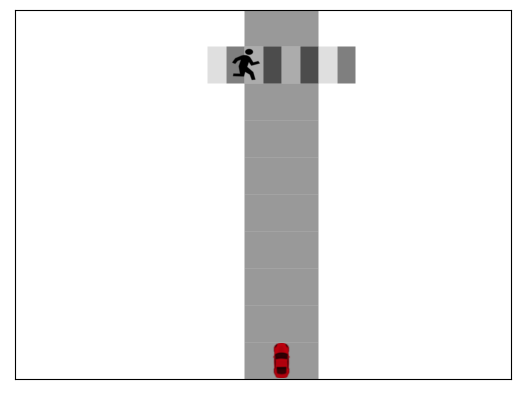

<Figure size 640x480 with 0 Axes>

In [4]:
class Grid():
    def __init__(self):
        self.xc_init = 0
        self.vc_init = 0
        self.ped = 1
        self.N = 10
        self.Vmax = 2
        self.xped = 10-CROSSWALK_V
        self.main_dir = os.path.dirname(os.path.dirname(os.path.realpath("__file__")))
        self.car_fig = self.main_dir + '/evaluating_perception/imglib/red_car.png'
        self.ped_fig = self.main_dir + '/evaluating_perception/imglib/pedestrian_img.png'
        self.car_data = [9, 0]
        if self.ped == 1:
            self.ped_data = [CROSSWALK_V, min(ped_loc)]
        else:
            self.ped_data = None
    
    def dynamics(self):
        transitions = dict()
        for x in range(0, self.N):
            x_succ = []
            for v in range(0, self.Vmax):
                x_succ.append(x + v)
            transitions[x] = x_succ
        return transitions
    
    def plot_grid(self):
        size = [1, self.N]
        x_min = 0
        x_max = size[0] * TILESIZE
        y_min = 0
        y_max = size[1] * TILESIZE
        # x_min, x_max, y_min, y_max = get_map_corners(map)
        
        fig, ax = plt.subplots()
        ax.axis('equal')
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        # fill in the road regions
        road_tiles = []
        width_tiles = np.arange(0,size[0]+1)*2*TILESIZE
        lanes_tiles = np.arange(0,size[1]+1)*TILESIZE
        
        for i in np.arange(0,size[0]):
            for k in np.arange(0,size[1]+1):
                tile = patches.Rectangle((width_tiles[i],lanes_tiles[k]),2*TILESIZE,TILESIZE,linewidth=1,facecolor='k', alpha=0.4)
                road_tiles.append(tile)
        ax.add_collection(PatchCollection(road_tiles, match_original=True))

        # now add crosswalk on top
        crosswalk_tiles = []
        for item in CROSSWALK_LOCATIONS.keys():
            if item % 2 == 0:
                color = 'silver'
                alpha = 0.5
            else:
                color = 'k'
                alpha = 0.5
            width = CROSSWALK_LOCATIONS[item][0]*TILESIZE
            lanes = CROSSWALK_LOCATIONS[item][1]*TILESIZE
            tile = patches.Rectangle((width,lanes),TILESIZE/2,TILESIZE,linewidth=1,facecolor=color, alpha=alpha)
            crosswalk_tiles.append(tile)
        ax.add_collection(PatchCollection(crosswalk_tiles, match_original=True))
        plt.gca().invert_yaxis()
        return ax
    
    
    def plot_car(self, ax):
        y_tile, speed = self.car_data
        theta_d = 270 # Rotate car to face north
        x = (1) * TILESIZE/2
        y = (y_tile) * TILESIZE
        car_fig = Image.open(self.car_fig)
        car_fig = car_fig.rotate(theta_d, expand=False)
        offset = 0.1
        ax.imshow(car_fig, zorder=1, interpolation='bilinear', extent=[x+2, x+TILESIZE-2, y+2, y+TILESIZE-2])
        return ax
    
    def plot_ped(self, ax):
        y_tile, x_tile = self.ped_data
        x = (x_tile) * TILESIZE/2
        y = (y_tile) * TILESIZE
        ped_fig = Image.open(self.ped_fig)
        ped_fig = ped_fig.rotate(180, expand=False)
        offset = 0.1
        ax.imshow(ped_fig, zorder=1, interpolation='bilinear', extent=[x+4, x+TILESIZE-2, y+2, y+TILESIZE-2])
        return ax

# Generate grid and figure:
grid = Grid()
ax = grid.plot_grid()
ax = grid.plot_car(ax)
ax = grid.plot_ped(ax)


plt.show()
plt.savefig(grid.main_dir + "/evaluating_perception/imglib/car_ped_ex.png")

## Controller contract for pedestrian and not pedestrian environments
The system contract is the overall system contract on whether the car should stop for a pedestrian or not.

In [73]:
## Controller contract with pedestrian and no pedestrian
## System contract: P >= 0.99
def system_contract():
    system_contract = {
        "input_vars":[
             "x_e"
        ],
        "output_vars":[
            "P_ped", "P_notped"
        ],
        "assumptions":
        [
             {"coefficients":{"x_e":-1}, "constant":-1},
             {"coefficients":{"x_e":1}, "constant":1}
        ],
        "guarantees":
        [
            {"coefficients":{"P_ped":-1},
            "constant":-0.99},
            {"coefficients":{"P_ped":1},
            "constant":1},
            {"coefficients":{"P_notped":-1},
            "constant":-0.90},
            {"coefficients":{"P_notped":1},
            "constant":1}
        ]}
    return system_contract

## Perception contract P = p**5 = 5p - 4
# Control contract for pedestrian
def control_contract_ped():
    mc= dict()
    mc = {"input_vars":["p_ped"],
        "output_vars":[
            "P_ped"
        ],
        "assumptions":
        [
            {"coefficients":{"p_ped":1},
            "constant":1},
            {"coefficients":{"p_ped":-1},
            "constant":0}
        ],
        "guarantees":
        [
          {"coefficients":{"P_ped":1, "p_ped":-5},
          "constant":-4},
          {"coefficients":{"P_ped":-1, "p_ped":5},
          "constant":4}
        ]}
    return mc

## Perception contract P = p**5 = 5(1-p) - 4
# Control contract for pedestrian
def control_contract_not_ped():
    mc= dict()
    mc = {"input_vars":["p_notped"],
        "output_vars":[
            "P_notped"
        ],
        "assumptions":
        [
            {"coefficients":{"p_notped":1},
            "constant":1},
            {"coefficients":{"p_notped":-1},
            "constant":0}
        ],
        "guarantees":
        [
          {"coefficients":{"P_notped":1, "p_notped":-4.2},
          "constant":-3.2},
          {"coefficients":{"P_notped":-1, "p_notped":4.2},
          "constant":3.2}
        ]}
    return mc

Cs = readContract(system_contract())
Ck_ped = readContract(control_contract_ped())
Ck_notped = readContract(control_contract_not_ped())


print("Overall System Contract:\n" + str(Cs)+"\n")
print("Controller Contract (true env: ped):\n" + str(Ck_ped)+"\n")
print("Controller Contract (true env:not ped):\n" + str(Ck_ped)+"\n")

# Quotient for ped controller
Cpped = Cs.quotient(Ck_ped)
print("Quotient Contract:\n" + str(Cpped)+"\n")

# Quotient for not ped controller:
Cp = Cs.quotient(Ck_notped)
print("Quotient Contract:\n" + str(Cp)+"\n")

# Composed contract:
Ck_comp = Ck_ped.compose(Ck_notped)
print("Composed Control Contract:\n" + str(Ck_comp)+"\n")

Cp = Cs.quotient(Ck_comp)
print("Quotient Contract for composed control contract:\n" + str(Cp)+"\n")

Overall System Contract:
InVars: [<Var x_e>]
OutVars:[<Var P_ped>, <Var P_notped>]
A: -1*x_e <= -1, 1*x_e <= 1
G: -1*P_ped <= -0.99, 1*P_ped <= 1.0, -1*P_notped <= -0.9, 1*P_notped <= 1.0

Controller Contract (true env: ped):
InVars: [<Var p_ped>]
OutVars:[<Var P_ped>]
A: 1*p_ped <= 1, -1*p_ped <= 0
G: 1*P_ped + -5*p_ped <= -4, -1*P_ped + 5*p_ped <= 4

Controller Contract (true env:not ped):
InVars: [<Var p_ped>]
OutVars:[<Var P_ped>]
A: 1*p_ped <= 1, -1*p_ped <= 0
G: 1*P_ped + -5*p_ped <= -4, -1*P_ped + 5*p_ped <= 4

Quotient Contract:
InVars: [<Var x_e>]
OutVars:[<Var P_notped>, <Var p_ped>]
A: -1*x_e <= -1, 1*x_e <= 1
G: -5*p_ped <= -4.99000000000000, -1*P_notped <= -0.9, 1*P_notped <= 1.0, 1*p_ped <= 1

Quotient Contract:
InVars: [<Var x_e>]
OutVars:[<Var P_ped>, <Var p_notped>]
A: -1*x_e <= -1, 1*x_e <= 1
G: -1*P_ped <= -0.99, 1*P_ped <= 1.0, -4.20000000000000*p_notped <= -4.10000000000000, 1*p_notped <= 1

Composed Control Contract:
InVars: [<Var p_ped>, <Var p_notped>]
OutVars:[

In [44]:
# Need to specify Markov Chain as a symbolic library
class MC():
    def __init__(self, states, transitions, goal):
        self.S = states
        self. T = transitions
        self.F = goal
        self.P = {t: 0 for t in self.T} # Initialize transition probabilities
        
    def read_probabilities(self, transitions, P):
        pass

class CM():
    def __init__(self, classes):
        self.classes = classes
        self.row_data_type = "predicted_class"
        self.col_data_type = "true_class"
        self.class_dict = {i: classes[i] for i in range(len(classes))}
        self.rev_class_dict = {v: k for k,v in self.class_dict.items()}
        self.cm = np.zeros((len(classes)))
    
    def set_cm(self, cm):
        self.cm = cm
    
    def get_tpr(self, class_i):
        class_ind = self.rev_class_dict[class_i]
        return self.cm[class_ind, class_ind]
    
    def get_fpr(self, class_i):
        class_ind = self.rev_class_dict[class_i]
        fpr = sum(self.cm[class_ind, :]) - self.cm[class_ind, class_ind]
        return fpr
    
    def get_fnr(self, class_i):
        class_ind = self.rev_class_dict[class_i]
        total_samples = self.get_total_samples(class_i)
        return total_samples - self.cm[class_ind, class_ind]
    
    def get_total_samples(self, class_i):
        class_ind = self.rev_class_dict[class_i]
        total_samples = sum(self.cm[:, class_ind])
        return total_samples 
    
    def get_normalized_metrics(self, class_i):
        total_samples = self.get_total_samples(class_i)
        tpr = self.get_tpr(class_i)
        fpr = self.get_fpr(class_i)
        fnr = self.get_fnr(class_i)
        return tpr/total_samples, fpr/total_samples, fnr/total_samples
    
# Define child classes
class Proposition_CM():
    pass

class Distance_CM():
    pass

In [ ]:
## Object detection contract:
# Inputs: classes
# Outputs: true positive and false positive rates for each class
